In [ ]:
import scipy
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from IPython.display import clear_output 

In [ ]:
# Define the LeNet-5-like CNN architecture
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 12, kernel_size=5)
        self.batch_norm1 = nn.BatchNorm2d(12)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(12, 32, kernel_size=5)
        self.batch_norm2 = nn.BatchNorm2d(32)
        
        self.fc1 = nn.Linear(32 * 4 * 4, 256)
        self.dropout1 = nn.Dropout(0.5)
        
        self.fc2 = nn.Linear(256, 128)
        self.dropout2 = nn.Dropout(0.5)
        
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.batch_norm1(self.conv1(x))))
        x = self.pool(torch.relu(self.batch_norm2(self.conv2(x))))
        x = x.view(-1, 32 * 4 * 4)
        x = torch.relu(self.dropout1(self.fc1(x)))
        x = torch.relu(self.dropout2(self.fc2(x)))
        x = self.fc3(x)
        return x


# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set up the data loaders with normalization
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.2860,), (0.3530,))])
trainset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

clear_output()

In [ ]:
num_models = 50 
num_epochs = 10
eps = 0.05  # Stopping criteria threshold

for model_nb in range(num_models):
    # Initialize the model
    model = LeNet().to(device)

    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.05, weight_decay=5e-3)

    # Train the model
    prev_train_loss = float('inf')  # Previous train loss
    for epoch in range(num_epochs):
        running_loss = 0.0
        total_correct_epoch = 0
        total_samples_epoch = 0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_samples_epoch += labels.size(0)
            total_correct_epoch += (predicted == labels).sum().item()

        train_acc = (total_correct_epoch / total_samples_epoch) * 100
        train_loss = running_loss/len(trainloader)

        model.eval()
        total=0
        correct=0
        with torch.no_grad():
          for data in testloader:
              inputs, labels = data[0].to(device), data[1].to(device)

              outputs = model(inputs)

              _, predicted = torch.max(outputs.data, 1)
              total += labels.size(0)
              correct += (predicted == labels).sum().item()

        valid_acc = (correct / total) * 100

        print(f"Model {model_nb+1+40} - Epoch {epoch+1}: Train Acc. = {train_acc:.2f}% --- Valid Acc. = {valid_acc:.2f}% --- Train Loss = {train_loss:.4f}")

        # Check stopping criteria based on difference in train loss
        if epoch > 0:
            train_loss_relative_diff = abs(prev_train_loss - train_loss) / prev_train_loss
            if train_loss_relative_diff < eps:
                print(f"Stopping criteria met: Difference in train loss ({train_loss_relative_diff}) < {eps}")
                break
        
        prev_train_loss = train_loss

    # Save the model weights
    filename = f'model_weights_{model_nb+1+40}.pt'
    torch.save(model.state_dict(), filename)

    print(f"Finished Training Model {model_nb+1+40}")


Model 41 - Epoch 1: Train Acc. = 75.23% --- Valid Acc. = 84.21% --- Train Loss = 0.6939
Model 41 - Epoch 2: Train Acc. = 86.11% --- Valid Acc. = 86.16% --- Train Loss = 0.3759
Model 41 - Epoch 3: Train Acc. = 87.94% --- Valid Acc. = 86.78% --- Train Loss = 0.3286
Model 41 - Epoch 4: Train Acc. = 88.82% --- Valid Acc. = 84.52% --- Train Loss = 0.3075
Model 41 - Epoch 5: Train Acc. = 89.29% --- Valid Acc. = 85.58% --- Train Loss = 0.2943
Stopping criteria met: Difference in train loss (0.04306458085799723) < 0.05
Finished Training Model 41
Model 42 - Epoch 1: Train Acc. = 73.84% --- Valid Acc. = 82.60% --- Train Loss = 0.7204
Model 42 - Epoch 2: Train Acc. = 86.22% --- Valid Acc. = 87.85% --- Train Loss = 0.3760
Model 42 - Epoch 3: Train Acc. = 88.25% --- Valid Acc. = 86.81% --- Train Loss = 0.3236
Model 42 - Epoch 4: Train Acc. = 88.96% --- Valid Acc. = 85.62% --- Train Loss = 0.3044
Model 42 - Epoch 5: Train Acc. = 89.52% --- Valid Acc. = 88.58% --- Train Loss = 0.2897
Stopping criteri

In [ ]:
# Project model onto L_inf ball of radius epsilon around the frozen weights
def project_weights(model, rho, fixed_w):
    with torch.no_grad():
        for i, param in enumerate(model.parameters()):
            param.data = torch.clamp(param.data, fixed_w[i]-(rho * abs(fixed_w[i])), fixed_w[i]+(rho * abs(fixed_w[i])))

In [ ]:
# Projected Gradient Ascent
num_models=50
nb_pga_epochs = 5  # Train for 5 epochs
rho = 1e-4
criterion = nn.CrossEntropyLoss()


# Loop over all trained models
for i in range(1, num_models+1): 
    best_eval_loss = float('-inf')  # Initialize best evaluation loss
    model = LeNet().to(device)
    # Load the learned weights into the model
    model.load_state_dict(torch.load(f"model_weights_{i}.pt"))
    optimizer = torch.optim.SGD(model.parameters(), lr=0.05)
    clone_w = [param.detach() for param in model.parameters()]

    for epoch in range(nb_pga_epochs):
        model.train()
        for data in trainloader:
            inputs, labels = data[0].to(device), data[1].to(device)

            optimizer.zero_grad()

            out = model(inputs)

            # Invert criterion to search for worst-case sharpness
            loss = -criterion(out, labels)
            loss.backward()
            optimizer.step()

            # Project weights onto the L_inf ball after each batch
            project_weights(model, rho, clone_w)

        # Evaluate loss on the training data for the last projected weights 
        model.eval()
        with torch.no_grad():
            total_loss = 0.0
            for data in trainloader:
                inputs, labels = data[0].to(device), data[1].to(device)
                out = model(inputs)
                loss = criterion(out, labels)
                total_loss += loss.item()
            average_loss = total_loss / len(trainloader)

        print(f"Model {i}, Epoch {epoch+1}: Loss = {average_loss:.4f}")

        if average_loss > best_eval_loss:
            # Save the model with the highest evaluation loss
            best_eval_loss = average_loss
            torch.save(model.state_dict(), f'PGD_weights_{i}.pt')

Model 40, Epoch 1: Loss = 0.7147
Model 40, Epoch 2: Loss = 0.7109
Model 40, Epoch 3: Loss = 0.7033
Model 40, Epoch 4: Loss = 0.7137
Model 40, Epoch 5: Loss = 0.7055
Model 41, Epoch 1: Loss = 0.8616
Model 41, Epoch 2: Loss = 0.8572
Model 41, Epoch 3: Loss = 0.8706
Model 41, Epoch 4: Loss = 0.8609
Model 41, Epoch 5: Loss = 0.8619
Model 42, Epoch 1: Loss = 0.8794
Model 42, Epoch 2: Loss = 0.8802
Model 42, Epoch 3: Loss = 0.8891
Model 42, Epoch 4: Loss = 0.8694
Model 42, Epoch 5: Loss = 0.8799
Model 43, Epoch 1: Loss = 0.7713
Model 43, Epoch 2: Loss = 0.7673
Model 43, Epoch 3: Loss = 0.7824
Model 43, Epoch 4: Loss = 0.7658
Model 43, Epoch 5: Loss = 0.7696
Model 44, Epoch 1: Loss = 0.7507
Model 44, Epoch 2: Loss = 0.7522
Model 44, Epoch 3: Loss = 0.7367
Model 44, Epoch 4: Loss = 0.7464
Model 44, Epoch 5: Loss = 0.7564
Model 45, Epoch 1: Loss = 0.8531
Model 45, Epoch 2: Loss = 0.8515
Model 45, Epoch 3: Loss = 0.8356
Model 45, Epoch 4: Loss = 0.8403
Model 45, Epoch 5: Loss = 0.8498
Model 46, 

In [ ]:
# Uncomment to download model files to local
# from google.colab import files
# for i in range(1,num_models+1):
#  files.download(f"model_weights_{i}.pt")
#  files.download(f'PGD_weights_{i}.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
def evaluate(model_weights, dataloader, criterion = nn.CrossEntropyLoss()):
  device= torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model= LeNet().to(device)
  model.load_state_dict(torch.load(model_weights))
  model.eval()
  with torch.no_grad():
      total_loss = 0.0
      for data in dataloader:
          inputs, labels = data[0].to(device), data[1].to(device)
          out = model(inputs)
          loss = criterion(out, labels)
          total_loss += loss.item()
      average_loss = total_loss / len(dataloader)
  return average_loss

In [ ]:
# Compute the sharpness (difference in train losses)
sharpness = [] 

for model_nb in range(num_models):
    #calculate train loss for original model
    original_loss = evaluate(f"model_weights_{model_nb+1}.pt", trainloader)

    #calculate train loss for updated model
    updated_loss = evaluate(f'PGD_weights_{model_nb+1}.pt', trainloader)

    # Record adaptive worst-case sharpness
    sharpness += [updated_loss - original_loss]

In [ ]:
# Compute the generalization (test loss)
generalization = []

for model_nb in range(num_models):
    #calculate test loss for original model
    test_loss = evaluate(f"model_weights_{model_nb+1}.pt", testloader)

    generalization += [test_loss]

In [ ]:
# Compute and save correlation coefficients
tau, pval = scipy.stats.kendalltau(sharpness, generalization)
print(tau, pval)
# str(tau)[:6]

-0.18040816326530612 0.06451074234674428


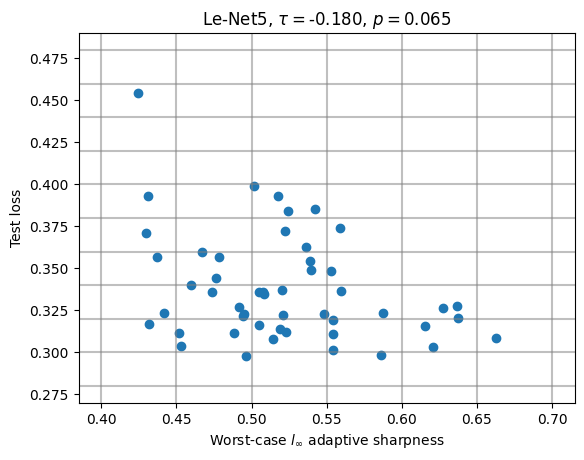

In [ ]:
# Create scatter plot
plt.scatter(sharpness, generalization)

# Add grey vertical lines
for x in plt.xticks()[0]:
    plt.axvline(x=x, color='grey', alpha=0.5)

# Add grey horizontal lines
for y in plt.yticks()[0]:
    plt.axhline(y=y, color='grey', alpha=0.5)

# Set labels and title
plt.xlabel('Worst-case '+r'$l_{\infty}$'+' adaptive sharpness')
plt.ylabel('Test loss')
plt.title('Le-Net5, '+r'$\tau=$'+ f'{tau:.3f}' + r', $p=$' + f'{pval:.3f}')

# Display the plot
plt.show()